In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})


In [2]:
from scipy.constants import e, m_p, c

from scipy.constants import physical_constants

In [3]:
from cpymad.madx import Madx

import pysixtracklib as pyst

In [4]:
nmass = physical_constants['atomic mass constant energy equivalent in MeV'][0] * 1e-3
nmass = 0.931494061 # MAD-X value

# 18.88 equal tune case!

## Load linear MAD-X lattice for SIS100 (cold quads only)

In [5]:
madx = Madx()
madx.options.echo = False


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.04.02  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2018.10.03               +
  + Execution date: 2019.06.05 18:44:28      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [6]:
madx.call(file="./2019-05-24--100turns-onlyquad/beam-distr.madx")

In [7]:
madxwarn = madx.options.warn
madx.options.warn = False
#madx.call(file=filename_error_table + '_full-lattice.seq')
# madx.call(file='./2019-05-23--100turns/SIS100RING_220618_nodipedge.thin.seq')
madx.call(file='./2019-05-24--100turns-onlyquad/SIS100QUADS.thin.seq')
madx.options.warn = madxwarn

In [8]:
madx.command.beam(particle='proton', energy=1)

True

In [9]:
madx.input('value, beam%sis100quads->gamma;')

beam%sis100quads->gamma =        1.065788933 ;


True

In [10]:
madx.input('value, beam%sis100quads->mass;')

beam%sis100quads->mass =       0.9382720813 ;


True

In [11]:
nmass_p = m_p/e*c**2
#nmass_p = 0.9382720813 * 1e9
nmass_p

938272081.4796857

In [12]:
Ekin = np.sqrt(1e9**2 - nmass_p**2)

In [13]:
# gamma recomputed to compare
np.sqrt((np.sqrt(1e9**2 - nmass_p**2) / nmass_p)**2 + 1)

1.065788932377661

In [14]:
madx.use(sequence='SIS100QUADS')

In [15]:
madx.input(
'''match, sequence=SIS100QUADS;
global, sequence=SIS100QUADS, q1=18.88, q2=18.88;
vary, name = kqf, step=0.0001;
vary, name = kqd, step=0.0001;
lmdif, tolerance=1e-20;
endmatch;
''')

START MATCHING

number of sequences: 1
sequence name: sis100quads
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   4.14120421e-24





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
kqf                       1.92906e-01  1.92906e-01 -1.00000e+20  1.00000e+20
kqd                      -1.92906e-01 -1.92906e-01 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   4.14120421e-24


True

In [16]:
madx.use(sequence='SIS100QUADS')

In [17]:
twiss = madx.twiss()

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0   -3.330669074e-16       -54794158.01 

                q1                dq1            betxmax              dxmax 
             18.88       -65.92076628        19.86530221                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0              18.88 

               dq2            betymax              dymax              dyrms 
      -65.92076628         19.8653033                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [18]:
sis100 = madx.sequence.SIS100QUADS

In [19]:
[f.name for f in map(lambda x: x.base_type, sis100.expanded_elements) 
 if 'drift' != f.name and 'multipole' != f.name and 'rfcavity' != f.name]

['marker', 'marker']

## Create MAD-X tracking files for comparison

In [20]:
nturns = 10000 #100 #2**16

In [21]:
# just for plotting reference
epsx = 35e-6 / 4 # geometrical emittances
epsy = 15e-6 / 4

In [22]:
madx.input('''
epsx_gauss=35e-6/4;
epsy_gauss=15e-6/4;
number_particles = 1000;
number_turns={:d};
ffile_stat=100;
gauss_cut=2;
'''.format(nturns))

True

### `nturns` turns:

In [23]:
madx.input("""
COPTION, SEED=987456321, PRINT=2;""")

True

In [24]:
madx.input('''
track, onepass,onetable;

n=0;
while(n<number_particles)
{
    exec, 6D_beam(gauss_cut,twiss);
    n=n+1;
}

run,turns=number_turns,ffile=ffile_stat;
endtrack;
''')

enter TRACK module
one pass is on
exit TRACK module



True

In [25]:
madx.command.write(table='tracksumm', file='madx_tracking_100turns.out')

True

### one turn, element by element:

In [26]:
madx.input("""
COPTION, SEED=987456321, PRINT=2;""")

True

In [27]:
madx.input('''
track, onepass, onetable, file=madx_tracking_oneturn.out;
'''
)

for elem_name in sis100.element_names()[1:-1]:
    madx.command.observe(place=elem_name)

madx.input('''
n=0;
while(n<number_particles)
{
    exec, 6D_beam(gauss_cut,twiss);
    n=n+1;
}

run,turns=1,ffile=1;
endtrack;
''')

enter TRACK module
one pass is on
exit TRACK module



True

# A. USING TRUNCATED DRIFT

## Load lattice and create beam in PySTL

In [22]:
elements = pyst.Elements.from_mad(sis100)

In [23]:
len(elements.get_elements())

339

In [24]:
elements.BeamMonitor(num_stores=1);

In [25]:
p0c = Ekin

In [26]:
npart = 1000
particles = pyst.Particles.from_ref(npart, p0c=p0c)

In [27]:
particles.gamma0[0]

1.0657889324020815

In [28]:
madx.command.value('beam->gamma;')

beam->gamma        =        1.065788933 ;


True

## Load MAD-X tracking results, write initial coordinates into PySTL particles

In [29]:
filename_tracksumm = './madx_tracking_100turns.out'

In [30]:
initial_distribution = np.genfromtxt(
    filename_tracksumm, skip_header=8, max_rows=1000)

In [31]:
headers = list(np.genfromtxt(
    filename_tracksumm, skip_header=6, max_rows=1, dtype=str)[1:])

In [32]:
initial_distribution.shape

(1000, 10)

In [33]:
final_distribution = np.genfromtxt(
    filename_tracksumm, skip_header=8 + 1000,)

In [34]:
final_distribution.shape

(1000, 10)

In [35]:
assert final_distribution.shape == initial_distribution.shape

In [36]:
assert final_distribution[0, 1] == nturns

In [37]:
x = final_distribution[:, headers.index('X')]
xp = final_distribution[:, headers.index('PX')]
y = final_distribution[:, headers.index('Y')]
yp = final_distribution[:, headers.index('PY')]
z = final_distribution[:, headers.index('T')] * particles.beta0
dp = final_distribution[:, headers.index('PT')] / particles.beta0

In [38]:
print ('sig_x: {}\nsig_y: {}\nsig_z: {}\nsig_dp: {}'.format(
    np.std(x), np.std(y), np.std(z), np.std(dp)))

sig_x: 0.007909920923108348
sig_y: 0.0042460918831466
sig_z: 5.107673808090061
sig_dp: 0.0


In [39]:
x = initial_distribution[:, headers.index('X')]
xp = initial_distribution[:, headers.index('PX')]
y = initial_distribution[:, headers.index('Y')]
yp = initial_distribution[:, headers.index('PY')]
z = initial_distribution[:, headers.index('T')] * particles.beta0
dp = initial_distribution[:, headers.index('PT')] / particles.beta0

In [40]:
print ('sig_x: {}\nsig_y: {}\nsig_z: {}\nsig_dp: {}'.format(
    np.std(x), np.std(y), np.std(z), np.std(dp)))

sig_x: 0.008567296814283466
sig_y: 0.00345077169709805
sig_z: 0.0
sig_dp: 0.0


In [41]:
assert not any((
    np.any(twiss['r11']), np.any(twiss['r12']), 
    np.any(twiss['r21']), np.any(twiss['r22']))
)

### $\implies$ TWISS doesn't indicate any global coupling (as for only quadrupoles there shouldn't be any!)! Remember, TWISS evaluates linear coupling only!

In [42]:
particles.x *= 0
particles.px *= 0
particles.y *= 0
particles.py *= 0
particles.zeta *= 0
particles.delta *= 0

particles.x += x
particles.px += xp
particles.y += y
particles.py += yp
particles.zeta += z
particles.delta += dp

## PySTL tracking and comparison to MAD-X

### element-by-element tracking for a single turn

In [43]:
job = pyst.TrackJob(elements, particles, device="opencl:0.1", until_turn_elem_by_elem=True)

In [44]:
job.track_elem_by_elem(1)

0

In [45]:
job.collect()

In [46]:
s = twiss['s'][::2]
beta_x = twiss['betx'][::2]
beta_y = twiss['bety'][::2]

p_id = 1

In [47]:
rec_x = job.output.particles[0].x
rec_y = job.output.particles[0].y

x_pystl = rec_x[p_id::npart][1:][::2]
y_pystl = rec_y[p_id::npart][1:][::2]

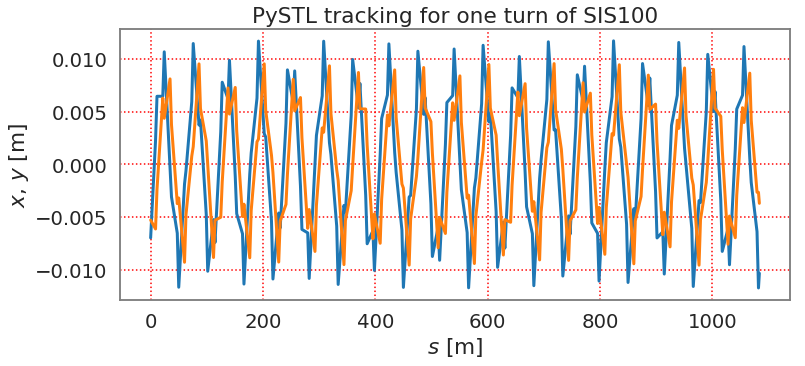

In [48]:
plt.figure(figsize=(12, 5))
plt.title('PySTL tracking for one turn of SIS100')
plt.xlabel('$s$ [m]')
plt.ylabel('$x$, $y$ [m]')
plt.plot(s, x_pystl)
plt.plot(s, y_pystl);

In [49]:
madx_ebye = np.genfromtxt('./madx_tracking_oneturn.outone', skip_header=54)

In [50]:
madx_ebye_headers = list(np.genfromtxt(
    './madx_tracking_oneturn.outone', skip_header=51, max_rows=1, dtype=str)[1:])

In [51]:
madx_ebye_elems = madx_ebye.reshape((len(sis100.elements), npart, madx_ebye.shape[1]))

In [52]:
x_madx = madx_ebye_elems[:, p_id, madx_ebye_headers.index('X')]
y_madx = madx_ebye_elems[:, p_id, madx_ebye_headers.index('Y')]

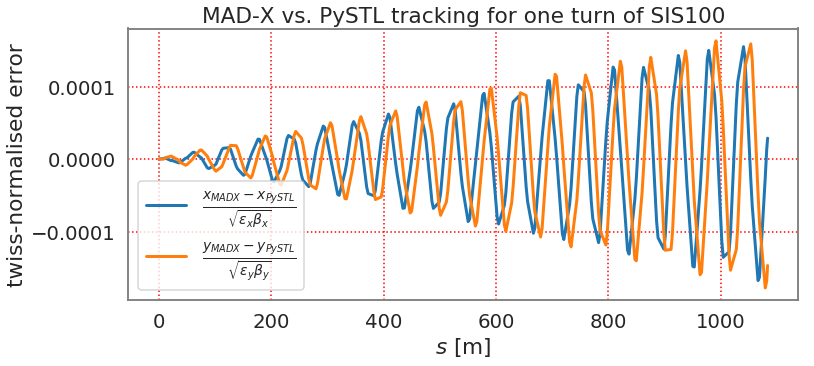

In [53]:
plt.figure(figsize=(12, 5))
plt.title('MAD-X vs. PySTL tracking for one turn of SIS100')
plt.xlabel('$s$ [m]')
plt.ylabel('twiss-normalised error')
plt.plot(s, (x_madx - x_pystl) / np.sqrt(epsx * beta_x), 
         label=r'$\frac{x_{MADX} - x_{PySTL}}{\sqrt{\epsilon_x\beta_x}}$')
plt.plot(s, (y_madx - y_pystl) / np.sqrt(epsy * beta_y), 
         label=r'$\frac{y_{MADX} - y_{PySTL}}{\sqrt{\epsilon_y\beta_y}}$')
plt.legend();
plt.savefig('tracking_madx_vs_pystl_drift-truncated.pdf', bbox_inches='tight')

### `nturns` tracking

In [54]:
del particles, elements, job

In [55]:
elements = pyst.Elements.from_mad(sis100)
elements.BeamMonitor(num_stores=nturns)

particles = pyst.Particles.from_ref(npart, p0c=p0c)

particles.x *= 0
particles.px *= 0
particles.y *= 0
particles.py *= 0
particles.zeta *= 0
particles.delta *= 0

particles.x += x
particles.px += xp
particles.y += y
particles.py += yp
particles.zeta += z
particles.delta += dp

In [56]:
job = pyst.TrackJob(elements, particles, device="opencl:0.1")

In [57]:
job.track(nturns)

0

In [58]:
job.collect()

In [59]:
rec_x = job.output.particles[0].x
rec_y = job.output.particles[0].y

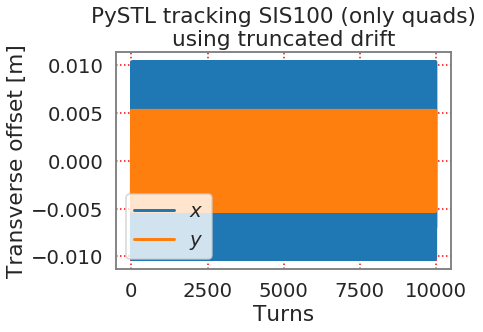

In [60]:
plt.plot(rec_x[1::npart], label='$x$')
plt.plot(rec_y[1::npart], label='$y$')
plt.legend()
plt.title('PySTL tracking SIS100 (only quads)\nusing truncated drift')
plt.xlabel('Turns')
plt.ylabel('Transverse offset [m]')
plt.savefig('./tracking_pystl_drift-truncated.pdf', bbox_inches='tight')

# B. USING EXACT DRIFT

In [61]:
del particles, elements, job

Let's replace loading the SixTrackLib `Drift` class by loading the `DriftExact` class when taking Drifts from MAD-X:

In [62]:
# hack fixing DriftExact
from pysixtracklib.beam_elements import Elements, DriftExact

Elements.element_types['Drift'] = DriftExact

In [63]:
elements = pyst.Elements.from_mad(sis100)

In [64]:
elements.BeamMonitor(num_stores=1);

In [65]:
npart = 1000
particles = pyst.Particles.from_ref(npart, p0c=p0c)

In [66]:
x = initial_distribution[:, headers.index('X')]
xp = initial_distribution[:, headers.index('PX')]
y = initial_distribution[:, headers.index('Y')]
yp = initial_distribution[:, headers.index('PY')]
z = initial_distribution[:, headers.index('T')] * particles.beta0
dp = initial_distribution[:, headers.index('PT')] / particles.beta0

In [67]:
particles.x *= 0
particles.px *= 0
particles.y *= 0
particles.py *= 0
particles.zeta *= 0
particles.delta *= 0

particles.x += x
particles.px += xp
particles.y += y
particles.py += yp
particles.zeta += z
particles.delta += dp

## PySTL tracking and comparison to MAD-X

### element-by-element tracking for a single turn

In [68]:
job = pyst.TrackJob(elements, particles, device="opencl:0.1", until_turn_elem_by_elem=True)

In [69]:
job.track_elem_by_elem(1)

0

In [70]:
job.collect()

In [71]:
s = twiss['s'][::2]
beta_x = twiss['betx'][::2]
beta_y = twiss['bety'][::2]

p_id = 1

In [72]:
rec_x = job.output.particles[0].x
rec_y = job.output.particles[0].y

x_pystl = rec_x[p_id::npart][1:][::2]
y_pystl = rec_y[p_id::npart][1:][::2]

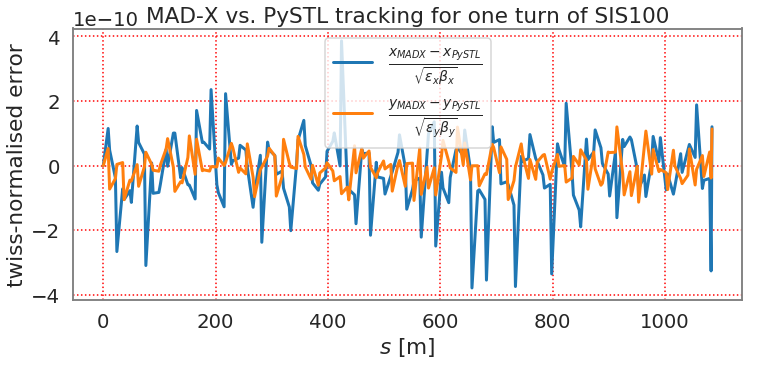

In [73]:
plt.figure(figsize=(12, 5))
plt.title('MAD-X vs. PySTL tracking for one turn of SIS100')
plt.xlabel('$s$ [m]')
plt.ylabel('twiss-normalised error')
plt.plot(s, (x_madx - x_pystl) / np.sqrt(epsx * beta_x), 
         label=r'$\frac{x_{MADX} - x_{PySTL}}{\sqrt{\epsilon_x\beta_x}}$')
plt.plot(s, (y_madx - y_pystl) / np.sqrt(epsy * beta_y), 
         label=r'$\frac{y_{MADX} - y_{PySTL}}{\sqrt{\epsilon_y\beta_y}}$')
plt.legend();
plt.savefig('tracking_madx_vs_pystl_drift-exact.pdf', bbox_inches='tight')

### `nturns` tracking

In [74]:
del particles, elements, job

In [75]:
elements = pyst.Elements.from_mad(sis100)
elements.BeamMonitor(num_stores=nturns)

particles = pyst.Particles.from_ref(npart, p0c=p0c)

particles.x *= 0
particles.px *= 0
particles.y *= 0
particles.py *= 0
particles.zeta *= 0
particles.delta *= 0

particles.x += x
particles.px += xp
particles.y += y
particles.py += yp
particles.zeta += z
particles.delta += dp

In [76]:
job = pyst.TrackJob(elements, particles, device="opencl:0.1")

In [77]:
job.track(nturns)

0

In [78]:
job.collect()

In [79]:
rec_x = job.output.particles[0].x
rec_y = job.output.particles[0].y

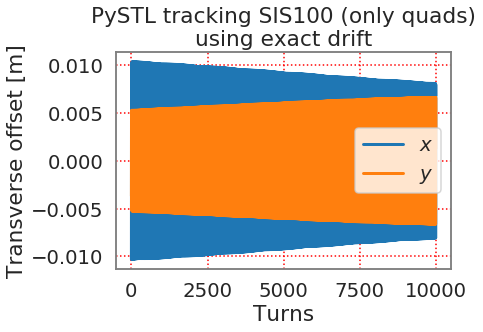

In [80]:
plt.plot(rec_x[1::npart], label='$x$')
plt.plot(rec_y[1::npart], label='$y$')
plt.legend()
plt.title('PySTL tracking SIS100 (only quads)\nusing exact drift')
plt.xlabel('Turns')
plt.ylabel('Transverse offset [m]')
plt.savefig('./tracking_pystl_drift-exact.pdf', bbox_inches='tight')

# $\implies$ the exact drift makes quite a difference in the SIS100 lattice!